In [1]:
# Configuration needs to come first
import os
os.environ['MKL_NUM_THREADS'] = '8'   # Enable multi-threading
os.environ['NSCLEAN_USE_CUPY'] = 'NO' # Use GPU. If you change this, you will
                                         #   need to restart python. In practice,
                                         #   I have found that most of the time
                                         #   the GPU is no faster than using CPUs.

# Import the appropriate numerical libraries
if os.getenv('NSCLEAN_USE_CUPY') == 'YES':
    import cupy as cp
    import numpy as np
else:
    import numpy as cp
    import numpy as np

# Other imports
from astropy.io import fits
from time import perf_counter as t # Used for benchmarking
from glob import glob
import matplotlib.pyplot as plt

# It will be handy to have a stack
time_stack = [] # Used for benchmarking

# NSClean specific
import nsclean as nc

# Make mask

In [2]:
# Make a list of input files
# files = sorted(glob("../data/rate_from_mast/*nrs1_rate.fits", recursive=True))
files = sorted(glob("../data/stage1/*nrs1_rate.fits", recursive=True))

In [3]:
files

['../data/stage1/jw01794001001_02101_00001_nrs1_rate.fits',
 '../data/stage1/jw01794001001_02101_00002_nrs1_rate.fits',
 '../data/stage1/jw01794001001_02101_00003_nrs1_rate.fits',
 '../data/stage1/jw01794001001_02101_00004_nrs1_rate.fits',
 '../data/stage1/jw01794001001_04101_00001_nrs1_rate.fits',
 '../data/stage1/jw01794001001_04101_00002_nrs1_rate.fits',
 '../data/stage1/jw01794001001_04101_00003_nrs1_rate.fits',
 '../data/stage1/jw01794001001_04101_00004_nrs1_rate.fits',
 '../data/stage1/jw01794001001_06101_00001_nrs1_rate.fits',
 '../data/stage1/jw01794001001_06101_00002_nrs1_rate.fits',
 '../data/stage1/jw01794001001_06101_00003_nrs1_rate.fits',
 '../data/stage1/jw01794001001_06101_00004_nrs1_rate.fits',
 '../data/stage1/jw01794001001_08101_00001_nrs1_rate.fits',
 '../data/stage1/jw01794001001_08101_00002_nrs1_rate.fits',
 '../data/stage1/jw01794001001_08101_00003_nrs1_rate.fits',
 '../data/stage1/jw01794001001_08101_00004_nrs1_rate.fits',
 '../data/stage1/jw01794001001_10101_000

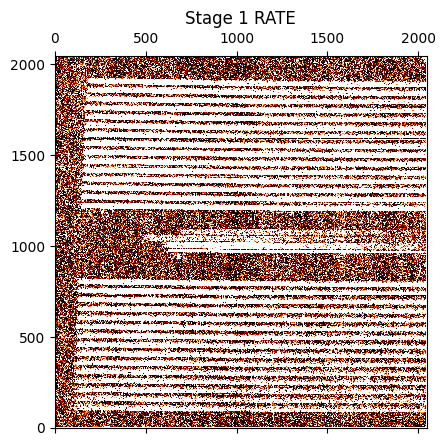

In [4]:
stage1_rate = fits.getdata(files[0])

plt.matshow((stage1_rate), cmap="gist_heat", origin="lower", 
            vmin=-0.005, 
            vmax=0.01)
plt.title("Stage 1 RATE")
plt.show()

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_6687/1573935884.py:4: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(stage2_cal), cmap="cubehelix", origin="lower",


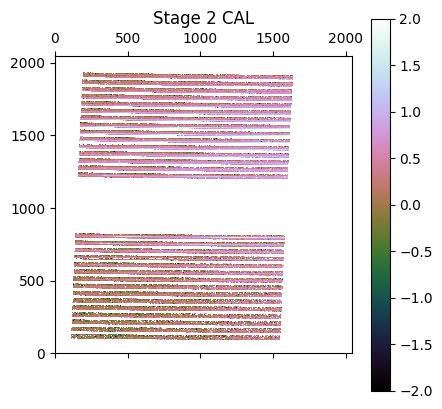

In [25]:
stage2_cal = fits.getdata("../data/stage2/jw01794001001_02101_00001_nrs1_cal.fits")


plt.matshow(np.log10(stage2_cal), cmap="cubehelix", origin="lower",
            vmin=-2, vmax=2
            )
plt.title("Stage 2 CAL")
plt.colorbar()
plt.show()

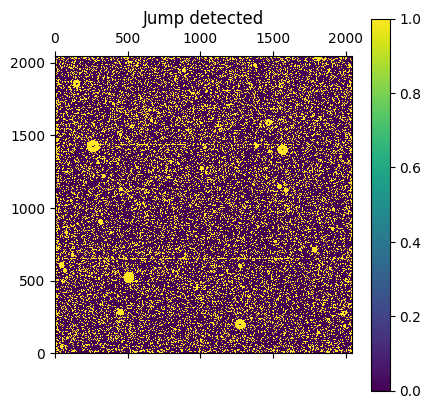

In [6]:
# dq_flag = fits.getdata("../data/stage1/jw01794001001_02101_00001_nrs1_rate.fits", 
#                        ext=3)
dq_flag = fits.getdata(files[0], 
                       ext=3)
jump_detected = (dq_flag & 4) == 4

plt.matshow(jump_detected, origin="lower")
plt.title("Jump detected")
plt.colorbar()

Pixels =0 are ignored. Pixels =1 are used for modeling the background. NSClean requires that the mask be passed as a boolean array.

In [1]:
mask = np.zeros_like(stage2_cal, dtype=np.bool_) 
mask[np.isnan(stage2_cal)] = True
mask[910:1140, 400:] = False

from scipy import ndimage 

plt.matshow(mask, origin="lower")
plt.title("Initial mask")
plt.show()

temp = mask.copy()
temp[jump_detected] = False

dilate_size = 2
not_mask = np.logical_not(temp)
not_mask = ndimage.binary_dilation(not_mask, 
                                   structure=np.ones((dilate_size, dilate_size))
                                   )

# 
# mask = ndimage.binary_dilation(mask, 
#                                    structure=np.ones((dilate_size, dilate_size))
#                                    )

plt.matshow(np.logical_not(not_mask), origin="lower")
plt.title("Dilated mask")
plt.show()

NameError: name 'np' is not defined

# Process NRS1 Files

In [8]:
# Instantiate an NSClean object

/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_6687/3703822330.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange((len(files))):


  0%|          | 0/22 [00:00<?, ?it/s]

Number of pixels with NaN values: 62646


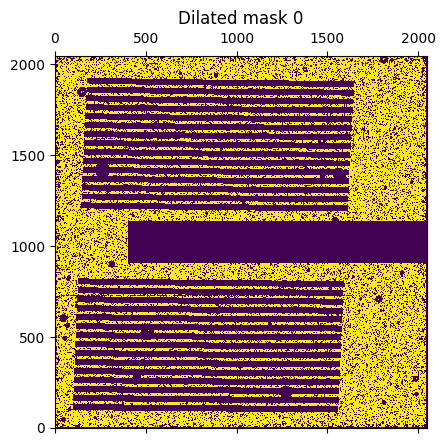

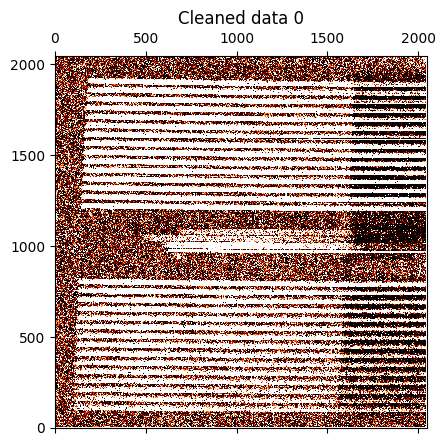

Execution time (s) =  605.1790197500959


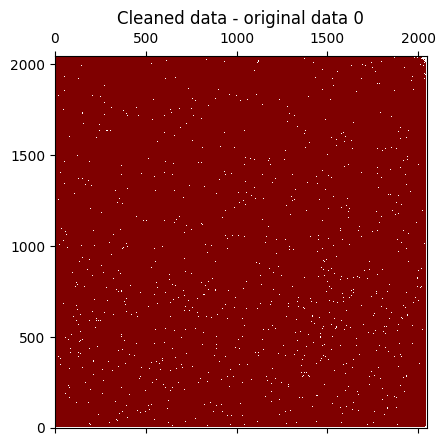

In [10]:
time_stack.append(t()) # Put start time on stack

from tqdm.notebook import tnrange

for i in tnrange(len(files)):
        
    with fits.open(files[i]) as hdul:
        header_0 = hdul[0].header
        header_1 = hdul[1].header
        data = cp.array(hdul[1].data)
    
    if i == 0:
        print(f"Number of pixels with NaN values: {np.sum(np.isnan(data))}")
    
    
    dq_flag = fits.getdata(files[0], 
                       ext=3)
    jump_detected = (dq_flag & 4) == 4
    
    temp = mask.copy()
    temp[jump_detected] = False
    temp[np.isnan(data)] = False
    
    dilate_size = 1
    not_mask = np.logical_not(temp)
    not_mask = ndimage.binary_dilation(not_mask, 
                                       structure=np.ones((dilate_size, dilate_size))
                                       )
    temp = np.logical_not(not_mask)
    
    #data = np.random.normal(loc=1000, scale=10, size=data.shape)
    
    if i == 0:
        plt.matshow(temp, origin="lower")
        plt.title(f"Dilated mask {i}")
        plt.show()

    cleaner = nc.NSClean('NRS1', temp)
    
    # Clean it
    clean_data = cleaner.clean(data, buff=True)
    
    
    if i == 0:
        plt.matshow(clean_data, cmap="gist_heat", origin="lower", 
                    vmin=-0.005, 
                    vmax=0.01
                    )
        plt.title(f"Cleaned data {i}")
        plt.show()
        
        plt.matshow(clean_data - data, cmap="gist_heat", origin="lower", 
                    vmin=-0.005, 
                    vmax=0.01
                    )
        plt.title(f"Cleaned data - original data {i}")
    
    # Save it to FITS
    header_0['comment'] = 'Processed by NSClean Rev. '+nc.__version__
    
    if os.getenv('NSCLEAN_USE_CUPY') == 'YES':
        hdul = fits.HDUList([fits.PrimaryHDU(header=header_0),
                   fits.ImageHDU(cp.asnumpy(clean_data), header=header_1, name='SCI')])
    else:
        hdul = fits.HDUList([fits.PrimaryHDU(header=header_0),
                   fits.ImageHDU(clean_data, header=header_1, name='SCI')])
        
    hdul.writeto('../data/nsclean_data/'+\
                     nc.chsuf(os.path.basename(files[i]), '.cln_mask.fits'),
                        overwrite=True)
    hdul.close()
    
    # break
    
print('Execution time (s) = ', t() - time_stack.pop())

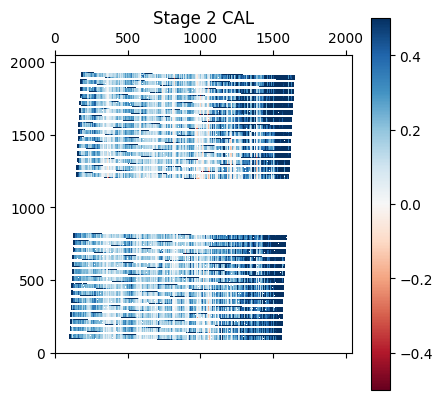

In [31]:
stage2_cal_nsclean = fits.getdata(
    "../data/stage2_nsclean/jw01794001001_02101_00001_nrs1_cal.fits"
)

plt.matshow((stage2_cal - stage2_cal_nsclean), cmap="RdBu", origin="lower",
            vmin=-.5, vmax=.5
            )
plt.title("Stage 2 CAL")
plt.colorbar()
plt.show()